# Univariate linear regression

In this tutorial, we introduce the univariate linear regression based PSM in `p2k`.

In [1]:
%load_ext autoreload
%autoreload 2

import p2k
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### Proxy

In [2]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = p2k.ProxyDatabase().from_df(df)

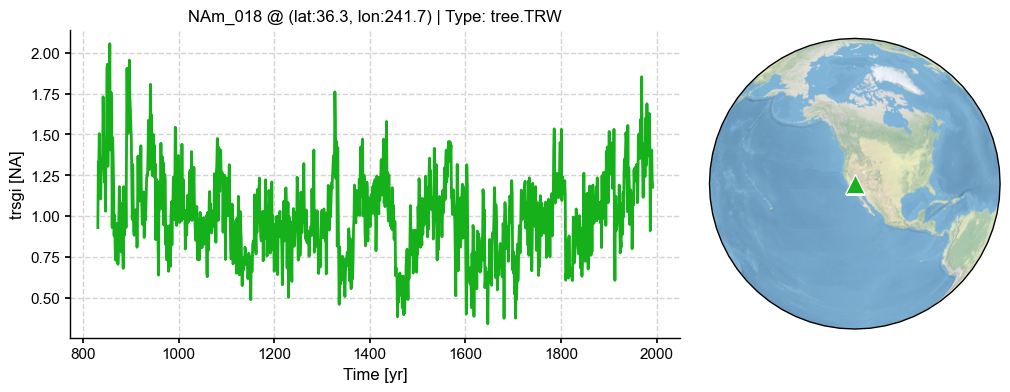

In [3]:
pobj = pdb.records['NAm_018']
fig, ax = pobj.plot()

### Model

In [4]:
dirpath = '/Volumes/ExtraDrive/Data/GCM_sims/icesm_last_millennium_historical'

model_tas = p2k.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
model_pr = p2k.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

In [5]:
model_tas.da

<xarray.DataArray 'tas' (time: 13872, lat: 96, lon: 144)>
[191766528 values with dtype=float32]
Coordinates:
  * time     (time) object 0850-01-17 00:00:00 ... 2005-12-17 00:00:00
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  Reference height temperature
    units:      K

In [7]:
print(np.median(np.diff(model_tas.da.lat)))
print(np.median(np.diff(model_tas.da.lon)))

1.8947372
2.5


### Instrumental observations

In [5]:
dirpath = '/Volumes/ExtraDrive/Data/Analyses/CRUTS'

obs_tas_ds = p2k.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp')
obs_pr_ds = p2k.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre')

In [6]:
obs_pr = obs_pr_ds.fields['pre'].rename('pr')
obs_tas = obs_tas_ds.fields['tmp'].rename('tas')

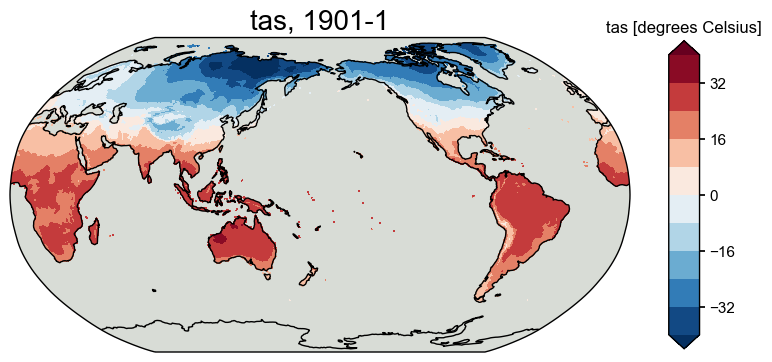

In [7]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

In [8]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 7.38 s, sys: 1.48 s, total: 8.86 s
Wall time: 8.9 s


In [9]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

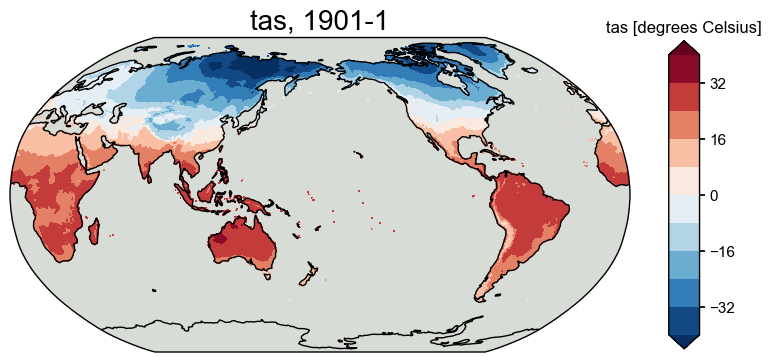

In [10]:
fig, ax = obs_tas_new.plot(levels=np.linspace(-40, 40, 11))

In [11]:
obs_pr.da.coords

Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [12]:
obs_pr_new = obs_pr.wrap_lon()

In [13]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for a specific `ProxyRecord`

In [14]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

ProxyRecord.clim deleted for NAm_018.
ProxyRecord.clim["model_tas"] created.
ProxyRecord.clim["model_pr"] created.
ProxyRecord.clim["obs_tas"] created.
ProxyRecord.clim["obs_pr"] created.
CPU times: user 98.3 ms, sys: 3.58 ms, total: 102 ms
Wall time: 102 ms


In [15]:
pobj.clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([ 0.4,  0.1,  0.5, ..., 10.3,  2.9,  0.9], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 36.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [16]:
lr_mdl = p2k.psm.Linear(pobj)

In [17]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list=sn_list)

CPU times: user 323 ms, sys: 4.96 ms, total: 328 ms
Wall time: 332 ms


In [18]:
lr_mdl.calib_details

{'df':         proxy   tas
 time               
 1901.0  1.518  0.25
 1902.0  1.321 -0.65
 1903.0  1.271 -2.60
 1904.0  1.257 -0.35
 1905.0  1.328  1.10
 ...       ...   ...
 1988.0  1.212  0.25
 1989.0  1.293 -1.65
 1990.0  1.405 -1.25
 1991.0  1.221  0.95
 1992.0  1.178 -0.60
 
 [92 rows x 2 columns],
 'nobs': 92.0,
 'fitR2adj': 0.021164846164224205,
 'PSMresid': time
 1901.0    0.243071
 1902.0    0.077992
 1903.0    0.097156
 1904.0    0.003352
 1905.0    0.022922
             ...   
 1988.0   -0.062929
 1989.0    0.085461
 1990.0    0.183274
 1991.0   -0.078758
 1992.0   -0.066781
 Length: 92, dtype: float64,
 'PSMmse': 0.04958769103827196,
 'SNR': 0.18158701386009884,
 'seasonality': [-12, 1, 2]}

In [19]:
%%time
pp = lr_mdl.forward()

CPU times: user 690 ms, sys: 23.7 ms, total: 714 ms
Wall time: 719 ms


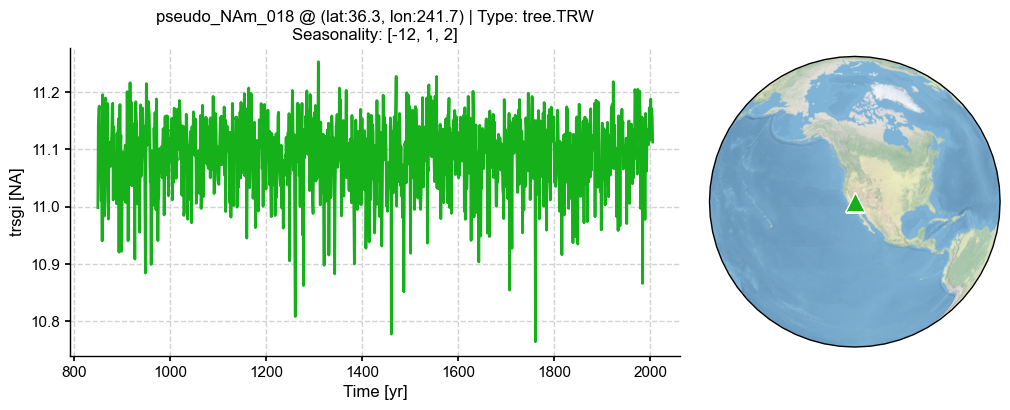

In [20]:
fig, ax = pp.plot()